Libraries installation + imports

In [1]:
!pip install h5py -q
!pip install pillow -q

In [2]:
import h5py
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from PIL import Image
from torchvision import transforms
import pandas as pd
import kagglehub
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import time
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
import io
from io import BytesIO
import cv2
from torchvision import transforms
import shutil

Donwload to the Google drive directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_dir = '/content/drive/MyDrive/ML_Project/kaggle'
!unzip  "{project_dir}/isic-2024-challenge.zip" -d /content/isic-2024-challenge;

Показано результат, скорочений до останніх рядків (5000).
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874656.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874659.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874663.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874742.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874751.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874803.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874805.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874832.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874878.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874897.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874925.jpg  
  inflating: /content/isic-2024-challenge/train-image/image/ISIC_9874931.

In [ ]:
root_dir = '/content/isic-2024-challenge'

Explore test dataset

In [ ]:
with h5py.File(f'{root_dir}/test-image.hdf5', 'r') as f:
    print("Keys in the file:", list(f.keys()))

    keys = list(f.keys())
    for key in keys:
        dataset = f[key]
        print(f"\nInspecting '{key}':")

        if dataset.shape == ():
            print(f"'{key}' is a scalar with value: {dataset[()]}")
        else:
            print(f"'{key}' is an array with shape: {dataset.shape}")
            plt.show()

Keys in the file: ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']

Inspecting 'ISIC_0015657':
'ISIC_0015657' is a scalar with value: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8d\x00\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x9

Visualize the train images

In [ ]:
metadata = pd.read_csv("/content/isic-2024-challenge/train-metadata.csv", low_memory=False)
metadata['target'].value_counts()

,count
target,
0,400666
1,393


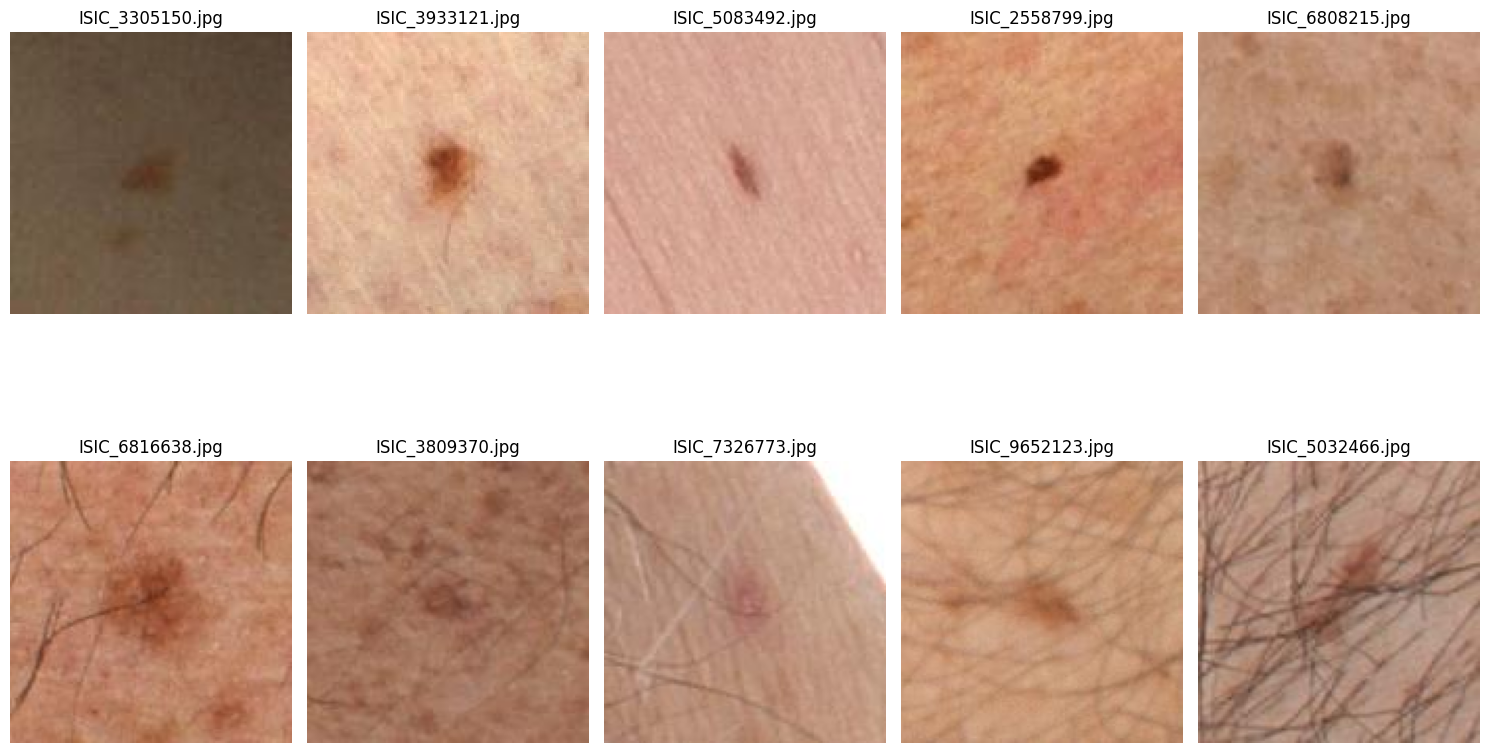

In [ ]:
image_dir = f'{root_dir}/train-image/image'

all_images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

random_images = random.sample(all_images, 10)

plt.figure(figsize=(15, 10))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)

plt.tight_layout()
plt.show()


Hair removal algorithm

In [ ]:
def remove_hair(image):
    """
    Remove hair artifacts from an image using the DullRazor approach.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 12, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)

    return inpainted

To check resutls of hair removal alforithm

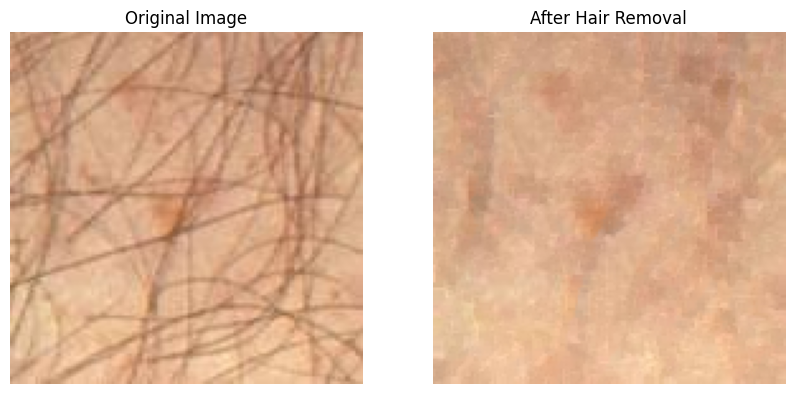

In [ ]:
def preprocess_image(image_path, output_size=(224, 224)):
    """
    Preprocess an image by removing hair, resizing, and normalizing.
    Also visualizes the image before and after hair removal.
    """
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    hair_removed_image = remove_hair(image_np)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hair_removed_image)
    plt.title("After Hair Removal")
    plt.axis('off')

    plt.show()

    hair_removed_image = Image.fromarray(hair_removed_image)

    preprocess_transform = transforms.Compose([
        transforms.Resize(output_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = preprocess_transform(hair_removed_image)

    return image_tensor

image_path = f'{root_dir}/train-image/image/ISIC_2314445.jpg'
preprocessed_image = preprocess_image(image_path)

Test dataset

In [ ]:
data = pd.read_csv(f'{root_dir}/train-metadata.csv')
selected_data = data[['isic_id', 'target']]

<ipython-input-11-870d3abfed9e>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{root_dir}/train-metadata.csv')


Split the data that we take all present malignant data and only 5K of benign data

In [ ]:
data_target_1 = selected_data[selected_data['target'] == 1]

num_samples_target_0 = 7000
data_target_0 = selected_data[selected_data['target'] == 0].sample(n=num_samples_target_0, random_state=42)
balanced_data = pd.concat([data_target_1, data_target_0], axis=0).reset_index(drop=True)

print(balanced_data['target'].value_counts())

target
0    7000
1     393
Name: count, dtype: int64


Add [ISIC-2020 dataset:](https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-256x256-resized)

In [ ]:
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")
print("Path to dataset files:", path)

100%|██████████| 325M/325M [00:20<00:00, 16.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


Move downloaded dataset to desired location

In [ ]:
!mv /root/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4 /content/isic-2024-challenge/isic-2020-dataset

Add new data to our dataset(only malignant images)

In [ ]:
file_list = os.listdir('/content/isic-2024-challenge/isic-2020-dataset/train/malignant/')

isic_2020_dataset = pd.DataFrame({
    'isic_id': ['ISIC2020_' + file for file in file_list],
    'target': 1
})

In [ ]:
merged_dataset = pd.concat([balanced_data, isic_2020_dataset], ignore_index=True)

Depicts data distribution

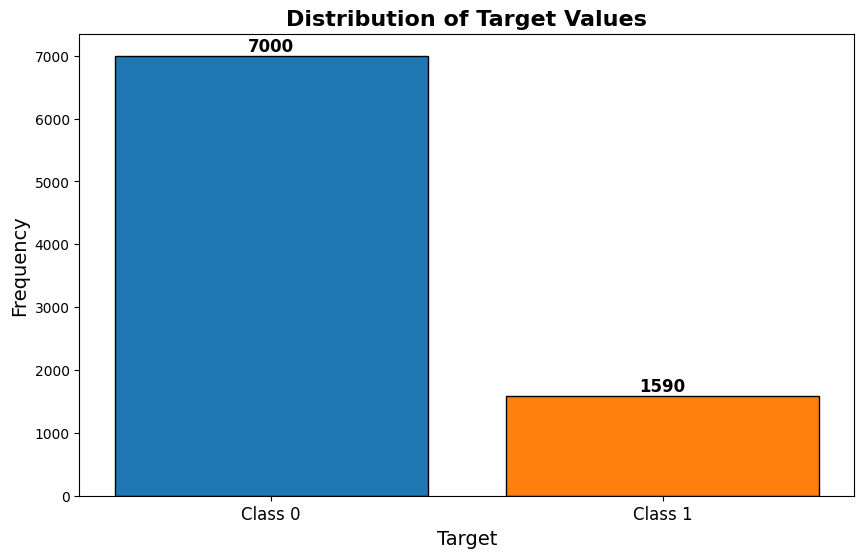

In [ ]:
value_counts = merged_dataset.target.value_counts()
plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values, color=['#1f77b4', '#ff7f0e'], edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, int(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Distribution of Target Values", fontsize=16, fontweight='bold')
plt.xlabel("Target", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks([0, 1], labels=['Class 0', 'Class 1'], fontsize=12)
plt.show()


Split the data in the equal proportions

In [ ]:
train_data, val_data = train_test_split(
    merged_dataset, test_size=0.2, stratify=merged_dataset['target'], random_state=42
)

Data Loader for our dataset

In [ ]:
class CassavaDataset(torch.utils.data.Dataset):
    def __init__(self, df, data_path='isic-2024-challenge/train-image/image/',
                 secondary_data_path="/content/isic-2024-challenge/isic-2020-dataset/train/malignant",
                 mode="train",
                 transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.secondary_data_path = secondary_data_path
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        if img_name.startswith("ISIC2020_"):
            stripped_name = img_name.replace("ISIC2020_", "")
            img_path = os.path.join(self.secondary_data_path, f"{stripped_name}")
        else:
            img_path = os.path.join(self.data_path, f"{img_name}.jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label


Dataset Preprocessing

In [ ]:
class HairRemovalTransform:
    def __call__(self, img):
        img_np = np.array(img)
        img_np = remove_hair(img_np)
        img = Image.fromarray(img_np)
        return img

IMG_SIZE = 224

transforms_train = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        HairRemovalTransform(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


model training

In [ ]:
model = models.mobilenet_v2(weights='IMAGENET1K_V2')

for param in model.parameters():
    param.requires_grad = False


In [ ]:
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model.classifier.add_module("Sigmoid", nn.Sigmoid())

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
train_dataset = CassavaDataset(train_data, data_path='isic-2024-challenge/train-image/image/', transforms=transforms_train)
valid_dataset = CassavaDataset(val_data, data_path='isic-2024-challenge/train-image/image/', transforms=transforms_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Epoch 1/8, Loss: 0.4634, Train Accuracy: 0.7942, Validation Accuracy: 0.8149
Epoch 2/8, Loss: 0.3567, Train Accuracy: 0.8270, Validation Accuracy: 0.8504
Epoch 3/8, Loss: 0.3146, Train Accuracy: 0.8849, Validation Accuracy: 0.9307
Epoch 4/8, Loss: 0.2833, Train Accuracy: 0.9117, Validation Accuracy: 0.9494
Epoch 5/8, Loss: 0.2646, Train Accuracy: 0.9251, Validation Accuracy: 0.9523
Epoch 6/8, Loss: 0.2487, Train Accuracy: 0.9306, Validation Accuracy: 0.9534
Epoch 7/8, Loss: 0.2430, Train Accuracy: 0.9325, Validation Accuracy: 0.9505
Epoch 8/8, Loss: 0.2332, Train Accuracy: 0.9363, Validation Accuracy: 0.9470


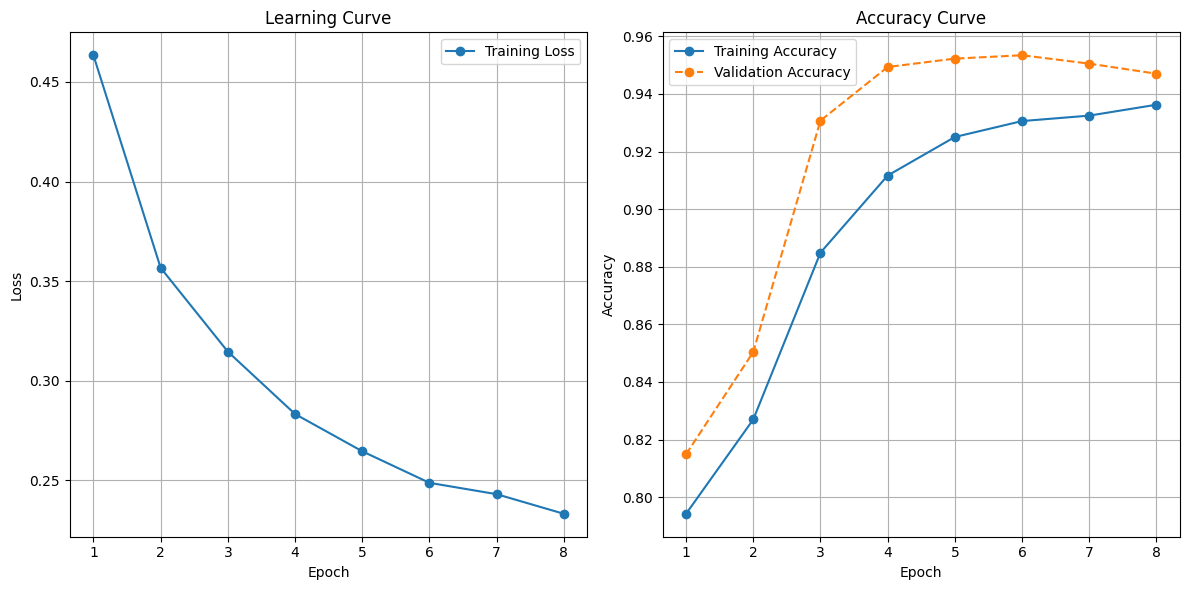

In [ ]:
train_accuracies = []
val_accuracies = []
loss_history = []

num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_history, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Epoch 1/20, Train Loss: 0.4619, Validation Loss: 0.4247, Train Accuracy: 0.8038, Validation Accuracy: 0.8149
Epoch 2/20, Train Loss: 0.3602, Validation Loss: 0.3758, Train Accuracy: 0.8255, Validation Accuracy: 0.8527
Epoch 3/20, Train Loss: 0.3137, Validation Loss: 0.3502, Train Accuracy: 0.8794, Validation Accuracy: 0.9336
Epoch 4/20, Train Loss: 0.2831, Validation Loss: 0.3297, Train Accuracy: 0.9141, Validation Accuracy: 0.9464
Epoch 5/20, Train Loss: 0.2646, Validation Loss: 0.3028, Train Accuracy: 0.9233, Validation Accuracy: 0.9488
Epoch 6/20, Train Loss: 0.2568, Validation Loss: 0.2879, Train Accuracy: 0.9278, Validation Accuracy: 0.9511
Epoch 7/20, Train Loss: 0.2421, Validation Loss: 0.2792, Train Accuracy: 0.9307, Validation Accuracy: 0.9523
Epoch 8/20, Train Loss: 0.2329, Validation Loss: 0.2702, Train Accuracy: 0.9363, Validation Accuracy: 0.9494
Epoch 9/20, Train Loss: 0.2261, Validation Loss: 0.2781, Train Accuracy: 0.9383, Validation Accuracy: 0.9464
Epoch 10/20, Train 

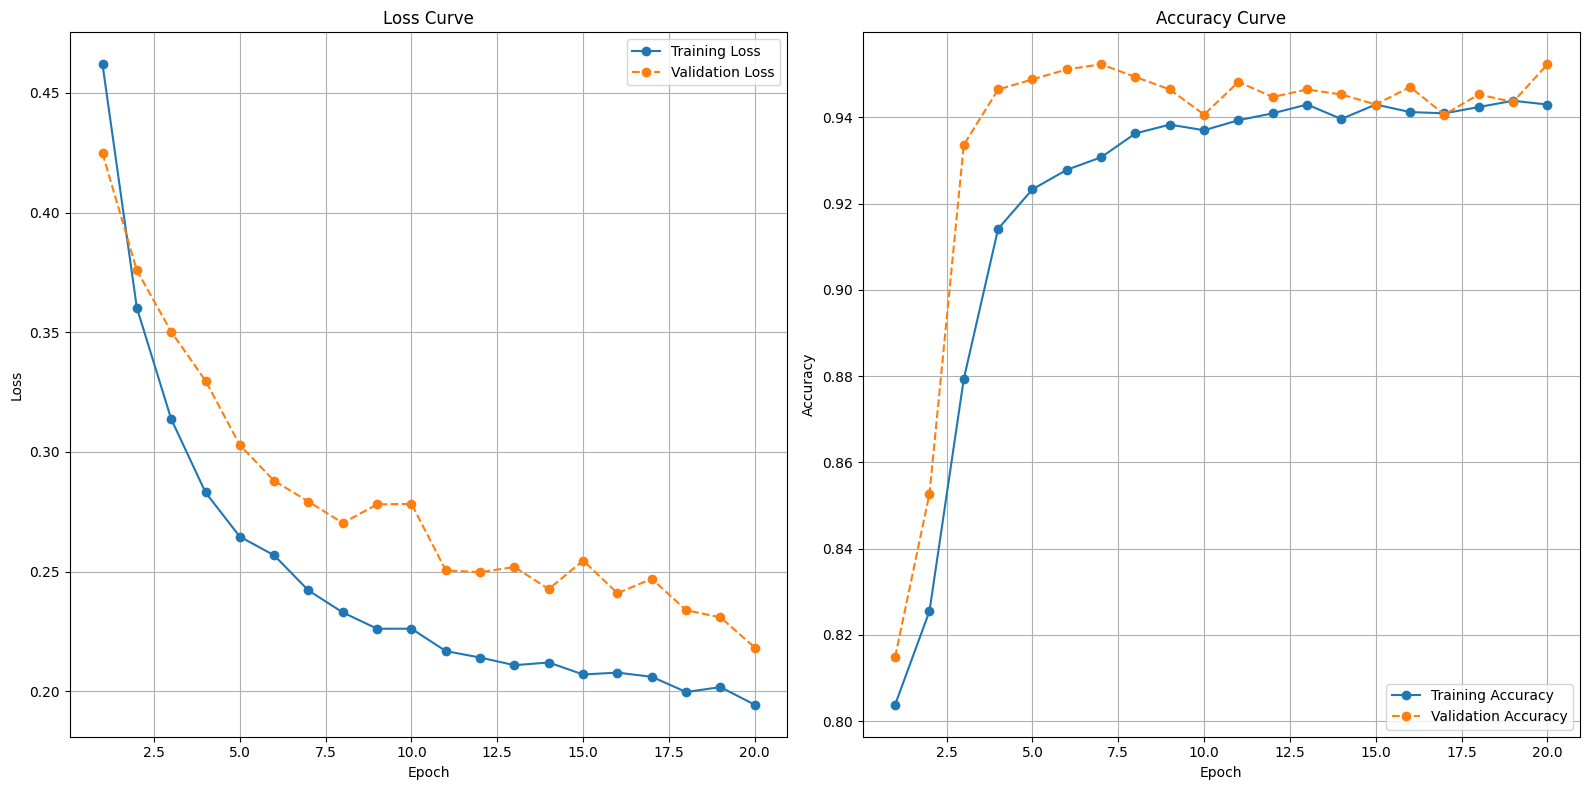

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_losses.append(epoch_val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
# Train Loss
train_loss = [0.4619, 0.3602, 0.3137, 0.2831, 0.2646, 0.2568, 0.2421, 0.2329, 0.2261, 0.2261,
              0.2168, 0.2141, 0.2109, 0.2120, 0.2070, 0.2078, 0.2060, 0.1997, 0.2017, 0.1944]

# Validation Loss
validation_loss = [0.4247, 0.3758, 0.3502, 0.3297, 0.3028, 0.2879, 0.2792, 0.2702, 0.2781, 0.2783,
                   0.2505, 0.2497, 0.2519, 0.2427, 0.2546, 0.2409, 0.2470, 0.2338, 0.2309, 0.2182]

# Train Accuracy
train_accuracy = [0.8038, 0.8255, 0.8794, 0.9141, 0.9233, 0.9278, 0.9307, 0.9363, 0.9383, 0.9370,
                  0.9393, 0.9409, 0.9430, 0.9396, 0.9430, 0.9412, 0.9409, 0.9424, 0.9438, 0.9430]

# Validation Accuracy
validation_accuracy = [0.8149, 0.8527, 0.9336, 0.9464, 0.9488, 0.9511, 0.9523, 0.9494, 0.9464, 0.9406,
                       0.9482, 0.9447, 0.9464, 0.9453, 0.9430, 0.9470, 0.9406, 0.9453, 0.9435, 0.9523]


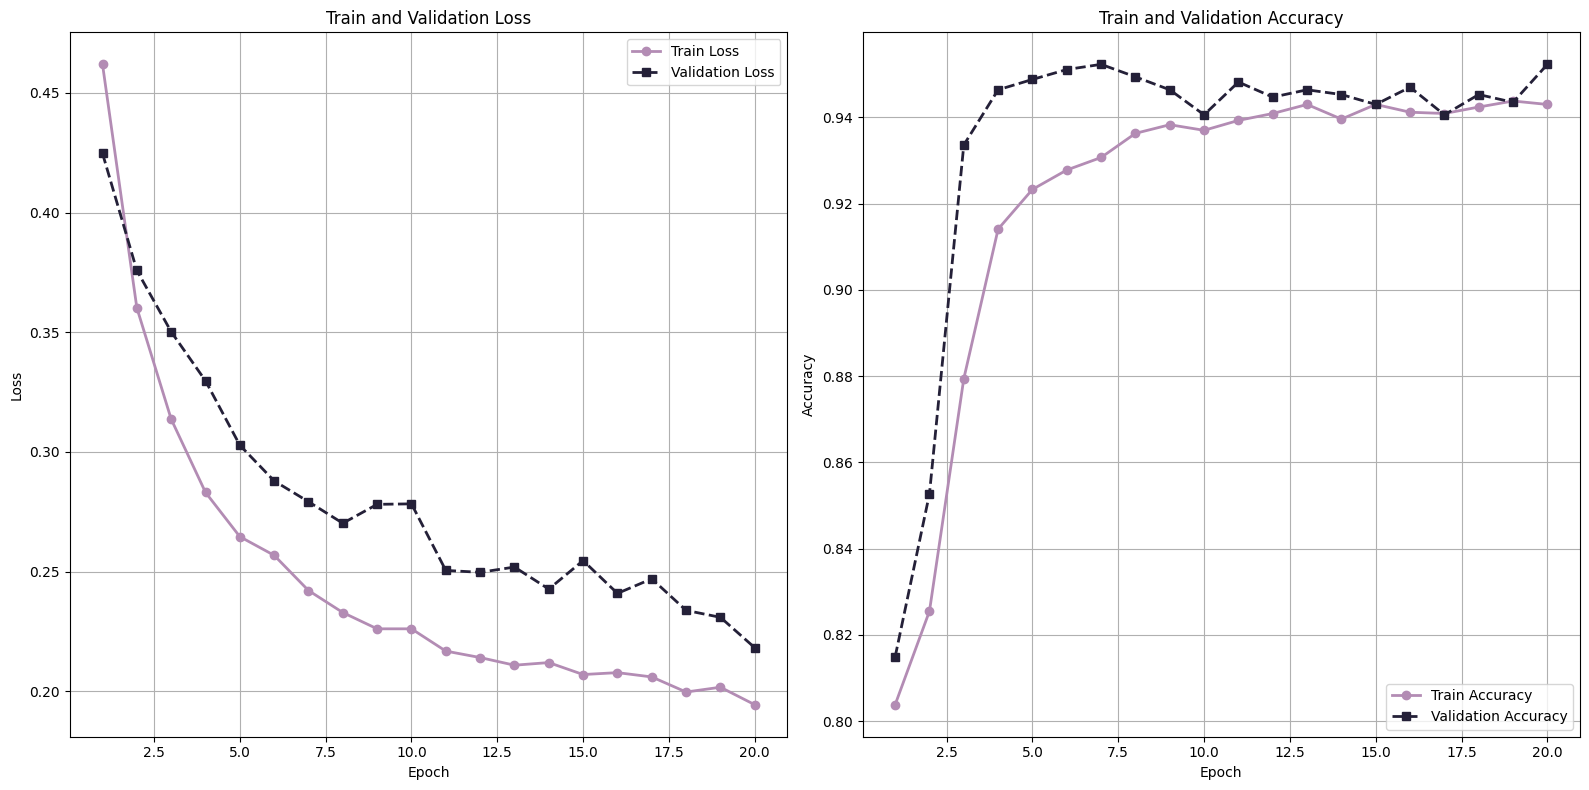

In [4]:
import matplotlib.pyplot as plt

# Dummy data for demonstration
num_epochs = 20


# Define the colors
train_color = '#B38CB4'  # Light purple for training
val_color = '#242038'    # Dark navy blue for validation

# Plotting
plt.figure(figsize=(16, 8))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, marker='o', color=train_color, label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), validation_loss, marker='s', linestyle='--', color=val_color, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, marker='o', color=train_color, label='Train Accuracy', linewidth=2)
plt.plot(range(1, num_epochs + 1), validation_accuracy, marker='s', linestyle='--', color=val_color, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, zero_division=1))


Accuracy: 0.9279
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1000
         1.0       0.91      0.78      0.84       318

    accuracy                           0.93      1318
   macro avg       0.92      0.88      0.90      1318
weighted avg       0.93      0.93      0.93      1318



In [ ]:
checkpoint_path = "/content/drive/MyDrive/ML_Project/checkpoints/model_checkpoint_v2_with_7000.pth"

checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss / len(train_loader),
    }
torch.save(checkpoint, checkpoint_path)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/ML_Project/checkpoints/model_checkpoint.pth"
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-31-b65b98a30b29>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(all_labels, all_preds, zero_division=1))

Accuracy: 0.9470
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1400
         1.0       0.93      0.77      0.84       318

    accuracy                           0.95      1718
   macro avg       0.94      0.88      0.91      1718
weighted avg       0.95      0.95      0.95      1718



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

probabilities = []
ground_truths = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        probabilities.extend(probs.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

In [ ]:
submission = pd.DataFrame({'probability': probabilities})
solution = pd.DataFrame({'ground_truth': ground_truths})

In [ ]:
submission.head()

,probability
0,0.694594
1,0.541308
2,0.530919
3,0.684898
4,0.709670


In [ ]:
solution.head()

,ground_truth
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
import optuna
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [ ]:
def score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float = 0.80) -> float:
    """
    Compute the partial area under the ROC curve (pAUC) above a given TPR threshold (min_tpr).
    """
    if not pd.api.types.is_numeric_dtype(submission.values.flatten()):
        raise ValueError("Submission target column must be numeric")

    v_gt = abs(np.asarray(solution.values) - 1)

    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)

    # Compute partial AUC
    partial_auc = auc(fpr, tpr)

    return partial_auc


In [ ]:
partial_auc = score(solution=solution, submission=submission, min_tpr=0.80)
print(f"Validation Partial AUC (pAUC): {partial_auc:.4f}")

Validation Partial AUC (pAUC): 0.1328


In [ ]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    return avg_loss


def validate(model, valid_loader, criterion, device):
    """
    Validate the model on the validation set.
    """
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(valid_loader)
    val_auc = roc_auc_score(all_labels, all_probs)
    return avg_loss, val_auc


In [ ]:
import json

# OPTUNA

In [ ]:


def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    """
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = 3

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model.classifier.add_module("Sigmoid", nn.Sigmoid())
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    best_val_auc = 0.0
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_auc = validate(model, valid_loader, criterion, device)

        best_val_auc = max(best_val_auc, val_auc)

        trial.report(val_auc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_auc


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best Trial:")
print(study.best_trial.params)

[I 2024-12-14 14:38:15,445] A new study created in memory with name: no-name-d98bbdb4-b7e2-4dd3-85be-8962532586cb
<ipython-input-49-c5bc052d155b>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-12-14 14:41:33,212] Trial 0 finished with value: 0.9595424528301886 and parameters: {'lr': 1.3530605450360778e-05, 'batch_size': 16}. Best is trial 0 with value: 0.9595424528301886.
<ipython-input-49-c5bc052d155b>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-12-14 14:44:28,084] Trial 1 finished with value: 0.966823899371069 and parameters: {'l

Best Trial:
{'lr': 0.00011310844584395686, 'batch_size': 64}


In [ ]:
best_params = study.best_trial.params
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f)


In [ ]:
import json

with open('best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)

final_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
final_model.classifier[1] = nn.Linear(final_model.classifier[1].in_features, 1)
final_model.classifier.add_module("Sigmoid", nn.Sigmoid())
final_model.to(device)

optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = nn.BCELoss()
final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_valid_loader = DataLoader(valid_dataset, batch_size=best_params['batch_size'], shuffle=False)

for epoch in range(best_params['epochs']):
    train_loss = train_one_epoch(final_model, final_train_loader, optimizer, criterion, device)
    val_loss, val_auc = validate(final_model, final_valid_loader, criterion, device)

    print(f"Epoch {epoch+1}/{best_params['epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")


# Cross Validation


===== Fold 1/5 =====
Epoch 1/10, Loss: 0.5293, Accuracy: 0.7444
Epoch 2/10, Loss: 0.4332, Accuracy: 0.7693
Epoch 3/10, Loss: 0.3912, Accuracy: 0.8350
Epoch 4/10, Loss: 0.3574, Accuracy: 0.8755
Epoch 5/10, Loss: 0.3428, Accuracy: 0.8923
Epoch 6/10, Loss: 0.3233, Accuracy: 0.9028
Epoch 7/10, Loss: 0.3075, Accuracy: 0.9104
Epoch 8/10, Loss: 0.3005, Accuracy: 0.9134
Epoch 9/10, Loss: 0.2889, Accuracy: 0.9151
Epoch 10/10, Loss: 0.2887, Accuracy: 0.9177
Validation Loss for Fold 1: 0.3091, Validation Accuracy: 0.9308

===== Fold 2/5 =====
Epoch 1/10, Loss: 0.5345, Accuracy: 0.7387
Epoch 2/10, Loss: 0.4415, Accuracy: 0.7700
Epoch 3/10, Loss: 0.3948, Accuracy: 0.8257
Epoch 4/10, Loss: 0.3675, Accuracy: 0.8772
Epoch 5/10, Loss: 0.3407, Accuracy: 0.8909
Epoch 6/10, Loss: 0.3258, Accuracy: 0.9042
Epoch 7/10, Loss: 0.3107, Accuracy: 0.9106
Epoch 8/10, Loss: 0.2996, Accuracy: 0.9113
Epoch 9/10, Loss: 0.2950, Accuracy: 0.9111
Epoch 10/10, Loss: 0.2881, Accuracy: 0.9158
Validation Loss for Fold 2: 0.

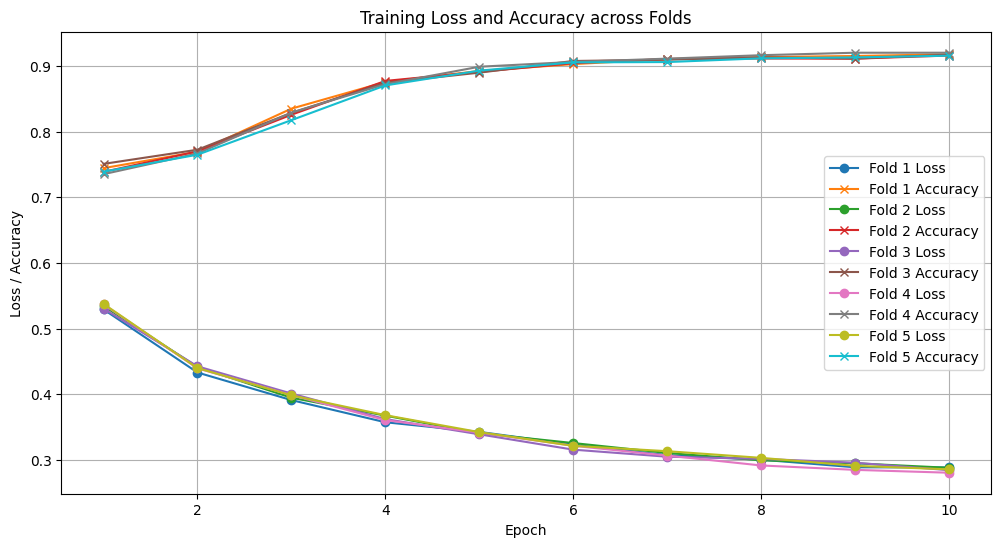

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

train_val_data, test_data = train_test_split(
    merged_dataset, test_size=0.2, stratify=merged_dataset['target'], random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_loss_history = []
fold_accuracy_history = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_data, train_val_data['target'])):
    print(f"\n===== Fold {fold+1}/{skf.get_n_splits()} =====")

    train_subset = train_val_data.iloc[train_idx]
    val_subset = train_val_data.iloc[val_idx]

    train_dataset = CassavaDataset(train_subset, data_path='isic-2024-challenge/train-image/image/', transforms=transforms_train)
    valid_dataset = CassavaDataset(val_subset, data_path='isic-2024-challenge/train-image/image/', transforms=transforms_valid)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

    model = models.mobilenet_v2(weights='IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model.classifier.add_module("Sigmoid", nn.Sigmoid())
    model.to(device)

    optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
    criterion = nn.BCELoss()

    num_epochs = 10
    fold_loss = []
    fold_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_samples
        fold_loss.append(epoch_loss)
        fold_accuracy.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    fold_loss_history.append(fold_loss)
    fold_accuracy_history.append(fold_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct_preds = 0
    val_total_samples = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            val_correct_preds += (preds == labels).sum().item()
            val_total_samples += labels.size(0)
    val_loss /= len(valid_loader)
    val_accuracy = val_correct_preds / val_total_samples
    print(f"Validation Loss for Fold {fold+1}: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(12, 6))

for i, (losses, accuracies) in enumerate(zip(fold_loss_history, fold_accuracy_history), 1):
    plt.plot(range(1, num_epochs + 1), losses, marker='o', label=f'Fold {i} Loss')
    plt.plot(range(1, num_epochs + 1), accuracies, marker='x', label=f'Fold {i} Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy across Folds')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_dataset = CassavaDataset(test_data, data_path='isic-2024-challenge/train-image/image/', transforms=transforms_train)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

probabilities = []
ground_truths = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        probabilities.extend(probs.cpu().numpy())
        ground_truths.extend(labels.cpu().numpy())

submission = pd.DataFrame({'probability': probabilities})
solution = pd.DataFrame({'ground_truth': ground_truths})

from sklearn.metrics import roc_curve, auc
import numpy as np

def score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float = 0.80) -> float:
    """
    Compute the partial area under the ROC curve (pAUC) above a given TPR threshold (min_tpr).
    """
    if not pd.api.types.is_numeric_dtype(submission.values.flatten()):
        raise ValueError("Submission target column must be numeric")

    # Rescale the ground truth: convert 0s to 1s and 1s to 0s
    v_gt = abs(np.asarray(solution.values) - 1)


    v_pred = -1.0 * np.asarray(submission.values)

    max_fpr = abs(1 - min_tpr)

    fpr, tpr, _ = roc_curve(v_gt, v_pred)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)

    # Compute partial AUC
    partial_auc = auc(fpr, tpr)

    return partial_auc

partial_auc = score(solution=solution, submission=submission, min_tpr=0.80)
print(f"Validation Partial AUC (pAUC): {partial_auc:.4f}")


Validation Partial AUC (pAUC): 0.1218


# Updated Model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(weights='IMAGENET1K_V2')

# Unfreeze the last few feature layers for fine-tuning
for param in model.features[:-4].parameters():
    param.requires_grad = False
for param in model.features[-4:].parameters():
    param.requires_grad = True

# Update the classifier for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.last_channel, 1),  # Binary classification with one output
)

# Move Sigmoid into the loss function for better numerical stability
criterion = nn.BCEWithLogitsLoss()

# Use AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the updated model structure
print(model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
num_epochs = 10
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(valid_loader)
    val_accuracy = correct_val / total_val

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping")
        break

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/10, Train Loss: 0.2524, Validation Loss: 0.1572, Train Accuracy: 0.9281, Validation Accuracy: 0.9546
Epoch 2/10, Train Loss: 0.1661, Validation Loss: 0.1551, Train Accuracy: 0.9491, Validation Accuracy: 0.9523
Epoch 3/10, Train Loss: 0.1586, Validation Loss: 0.1399, Train Accuracy: 0.9478, Validation Accuracy: 0.9558
Epoch 4/10, Train Loss: 0.1532, Validation Loss: 0.1419, Train Accuracy: 0.9504, Validation Accuracy: 0.9558
Epoch 5/10, Train Loss: 0.1447, Validation Loss: 0.1370, Train Accuracy: 0.9534, Validation Accuracy: 0.9534
Epoch 6/10, Train Loss: 0.1416, Validation Loss: 0.1375, Train Accuracy: 0.9531, Validation Accuracy: 0.9534
Epoch 7/10, Train Loss: 0.1373, Validation Loss: 0.1318, Train Accuracy: 0.9534, Validation Accuracy: 0.9558
Epoch 8/10, Train Loss: 0.1387, Validation Loss: 0.1408, Train Accuracy: 0.9555, Validation Accuracy: 0.9529
Epoch 9/10, Train Loss: 0.1428, Validation Loss: 0.1347, Train Accuracy: 0.9530, Validation Accuracy: 0.9546
Epoch 10/10, Train 